In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [37]:
rooth_path = 'data/'
deng_sj = pd.read_csv(rooth_path + 'deng_sj.csv')
deng_iq = pd.read_csv(rooth_path + 'deng_iq.csv')
test_sj = pd.read_csv(rooth_path + 'test_sj.csv')
test_iq = pd.read_csv(rooth_path + 'test_iq.csv')

In [38]:
dfs_train = [deng_sj, deng_iq]
dfs_test = [test_sj, test_iq]

In [39]:
# transform to feature week_start_date to datetime
def date_time(df):
    
    #setting a datetime index
    df.set_index('week_start_date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    return df

In [40]:
for df in dfs_train:
    df = date_time(df)

P-value: 5.1473186737591e-09


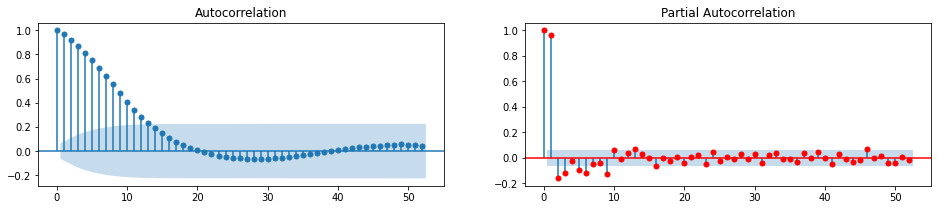

P-value: 1.0672522948401663e-07


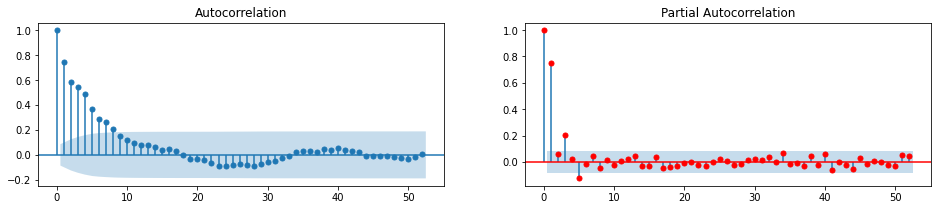

In [41]:
# Stationarity
for df in dfs_train:
    print(f'P-value: {adfuller(df.total_cases)[1]}') # p-value
    fig, axes = plt.subplots(1,2, figsize=(16,3))
    plot_acf(df.total_cases, lags=52, ax=axes[0]) # auto-correlation
    plot_pacf(df.total_cases, lags=52, ax=axes[1], color='r') # partial auto-correlation
    plt.show()

We can see that the p-value is close to 0 -> indicates stationarity

#### Covert Kelvin to Celsius

In [42]:
# 'reanalysis_air_temp_k','reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k'
# 'reanalysis_tdtr_k' -> There is no need to convert this feature, since is the difference between the maximum and minimum 

In [43]:
def convert_celsius(df):
    
    temp = 273,15
    
    # convert to celsius
    df['reanalysis_air_temp_k'] = df['reanalysis_air_temp_k'] - temp
    df['reanalysis_avg_temp_k'] = df['reanalysis_avg_temp_k'] - temp
    df['reanalysis_dew_point_temp_k'] = df['reanalysis_dew_point_temp_k'] - temp
    df['reanalysis_max_air_temp_k'] = df['reanalysis_max_air_temp_k'] - temp
    df['reanalysis_min_air_temp_k'] = df['reanalysis_min_air_temp_k'] - temp
    
    # change features names
    col = df.columns
    col = col.str.replace('temp_k', 'temp_c')
    df.columns = col.str.replace('tdtr_k', 'tdtr_c')
    
    return df

#### Mean of Normalized difference vegetation

In [47]:
def mean_ndvi(df):
    
    df['ndvi_mean'] = df[df.columns[3:7]].mean(axis = 1)
    
    return df

#### Rolling Features